In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets
from tqdm.notebook import tqdm
import torchvision
from torch import nn
import os
import pickle
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from torch.nn import functional as fnn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from utils import NUM_PTS, CROP_SIZE
from utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from utils import ThousandLandmarksDataset
from utils import restore_landmarks_batch, create_submission
import cv2
from torch.utils import data
import albumentations as A
from albumentations.pytorch import ToTensor


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:

TRAIN_SIZE = 0.8
NUM_PTS = 971
CROP_SIZE = 128
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"


In [5]:
PATH_TRAIN='data_clean'

In [7]:


class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        # self.size = torch.tensor(size, dtype=torch.float)
        self.size = np.asarray(size, dtype=np.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample


In [25]:
class MyAssDataset(data.Dataset):
    def __init__(self,images_paths,landmarks_path,preprocessing, transforms):
        super(MyAssDataset, self).__init__()
        
        landmark_file_name = landmarks_path
        

        self.image_paths = images_paths
        self.image_names = [os.path.split(path)[-1] for path in self.image_paths]
        self.landmarks=[]
        self.landmark_file = pd.read_csv(landmarks_path,sep='\t',index_col=['file_name'])

        with open(landmark_file_name, "rt") as fp:
            num_lines = sum(1 for line in fp)
        num_lines -= 1  # header

        for image_name in tqdm(self.image_names):
            elements=self.landmark_file.loc[image_name].values
                
                
                    
            landmarks = list(map(np.int, elements))
            landmarks = np.array(landmarks, dtype=np.int).reshape((len(landmarks) // 2, 2))
            self.landmarks.append(landmarks)   
                
        self.landmarks = torch.as_tensor(self.landmarks)
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        sample = {}
        
        landmarks = self.landmarks[idx]
        sample["landmarks"] = landmarks

        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image

        if self.preprocessing is not None:
            sample = self.preprocessing(sample)
            
#         sample['image'] = sample['image']
        
        if self.transforms is not None:
            sample = self.transforms(image=sample['image'].permute(1,2,0).numpy(), keypoints=sample['landmarks'].numpy().reshape(-1,2))
            sample['landmarks'] = torch.tensor(np.array(sample['keypoints'])).flatten()
        
#         keypoints=[]
#         for x,y in sample['keypoints']:
#             keypoints.append(x)
#             keypoints.append(y)
            
        
        return sample

    def __len__(self):
        return len(self.image_names)

In [26]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    
    plt.scatter(landmarks.reshape(-1,2)[:, 0], landmarks.reshape(-1,2)[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

In [27]:
train_preprocessing = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
     
])

In [53]:
train_transform = A.Compose([
        
        A.HorizontalFlip(p=0.5),
    A.Rotate(p=0.6),
#         A.OneOf([
#             A.HueSaturationValue(p=0.5), 
#             A.RGBShift(p=0.7)
#         ], p=1),                          
#         A.RandomBrightnessContrast(p=0.5),
#     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
    ToTensor()
    
    ], 
    keypoint_params=A.KeypointParams(format='xy'),
)

In [54]:
all_image_paths = [os.path.join(PATH_TRAIN,'images',name) for name in os.listdir(os.path.join(PATH_TRAIN,'images'))]

In [55]:
train_images,val_images=train_test_split(all_image_paths,test_size=0.33)

In [56]:
train_dataset  = MyAssDataset(train_images[:100],os.path.join(PATH_TRAIN, 'landmarks.csv'), preprocessing=train_preprocessing,transforms=train_transform)

In [76]:

a = train_dataset[14]

ValueError: Expected y for keypoint (59.760254, 128.32178, 0.0, 0) to be in the range [0.0, 128], got 128.32177734375.

In [75]:
i

14

In [58]:
a['image']

tensor([[[0.6139, 0.6534, 0.6772,  ..., 0.2554, 0.3048, 0.3520],
         [0.6426, 0.6749, 0.6936,  ..., 0.2525, 0.3007, 0.3488],
         [0.6738, 0.6952, 0.7106,  ..., 0.2608, 0.2886, 0.3275],
         ...,
         [0.0902, 0.1502, 0.2040,  ..., 0.8654, 0.8843, 0.8784],
         [0.1428, 0.1990, 0.2447,  ..., 0.8512, 0.8669, 0.8672],
         [0.2139, 0.2557, 0.2583,  ..., 0.8467, 0.8559, 0.8580]],

        [[0.5496, 0.5858, 0.6038,  ..., 0.2018, 0.2357, 0.2669],
         [0.5778, 0.6077, 0.6191,  ..., 0.2011, 0.2315, 0.2648],
         [0.6126, 0.6270, 0.6371,  ..., 0.2147, 0.2227, 0.2456],
         ...,
         [0.0785, 0.1386, 0.1922,  ..., 0.7086, 0.7299, 0.7290],
         [0.1347, 0.1897, 0.2354,  ..., 0.6941, 0.7133, 0.7163],
         [0.2061, 0.2477, 0.2485,  ..., 0.6937, 0.7029, 0.7064]],

        [[0.4823, 0.5154, 0.5357,  ..., 0.1094, 0.1506, 0.1918],
         [0.5139, 0.5391, 0.5520,  ..., 0.1066, 0.1446, 0.1854],
         [0.5480, 0.5623, 0.5704,  ..., 0.1167, 0.1298, 0.

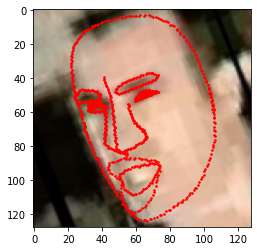

In [59]:
show_landmarks(a['image'].permute(1,2,0),a['landmarks'])

In [60]:
val_preprocessing = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
     
])

In [61]:
# train_transform = A.Compose([
        
#         A.HorizontalFlip(p=0.5),
#     A.Rotate(p=0.6),
# #         A.OneOf([
# #             A.HueSaturationValue(p=0.5), 
# #             A.RGBShift(p=0.7)
# #         ], p=1),                          
# #         A.RandomBrightnessContrast(p=0.5),
#     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
#     ToTensor()
    
#     ], 
#     keypoint_params=A.KeypointParams(format='xy'),
# )

In [62]:
val_dataset = MyAssDataset(val_images[:100],os.path.join(PATH_TRAIN, 'landmarks.csv'), preprocessing=val_preprocessing,transforms=None)

In [63]:
b = val_dataset[40]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


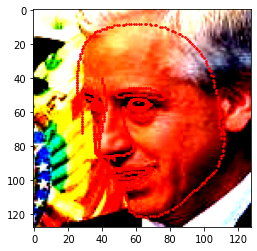

In [64]:
show_landmarks(b['image'].permute(1,2,0), b['landmarks'])
   

In [65]:

def train(model, loader, loss_fn, optimizer, device,scheduler):
    model.train()
    train_loss = []
    for batch in tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [66]:

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=6, pin_memory=True,
                              shuffle=True, drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True,
                            shuffle=False, drop_last=False)

In [67]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [68]:
model = torchvision.models.mobilenet_v2(pretrained=True)

In [69]:

model.requires_grad_(False)

model.classifier = nn.Linear(1280,971*2,bias=True)
model.classifier.requires_grad_(True)

model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [70]:

optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

loss_fn = fnn.mse_loss
EPOCHS=100
NUM_PREFIT_EPOCHS=3

In [71]:
PATH='contest01_data'
EXP_NAME='new_aug_1'

In [72]:
os.makedirs("runs", exist_ok=True)
best_val_loss = np.inf
for epoch in range(EPOCHS):
    if epoch>NUM_PREFIT_EPOCHS:
        model.requires_grad_(True)
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device,scheduler)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join("runs", f"{EXP_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-25-a22f39c9a6ac>", line 46, in __getitem__
    sample = self.transforms(image=sample['image'].permute(1,2,0).numpy(), keypoints=sample['landmarks'].numpy().reshape(-1,2))
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/core/composition.py", line 180, in __call__
    p.preprocess(data)
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/core/utils.py", line 62, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/core/utils.py", line 70, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/keypoints_utils.py", line 71, in convert_to_albumentations
    return convert_keypoints_to_albumentations(
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/keypoints_utils.py", line 185, in convert_keypoints_to_albumentations
    return [
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/keypoints_utils.py", line 186, in <listcomp>
    convert_keypoint_to_albumentations(kp, source_format, rows, cols, check_validity, angle_in_degrees)
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/keypoints_utils.py", line 148, in convert_keypoint_to_albumentations
    check_keypoint(keypoint, rows, cols)
  File "/home/ilyua/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/keypoints_utils.py", line 85, in check_keypoint
    raise ValueError(
ValueError: Expected y for keypoint (47.058823, 131.17647, 0.0, 0) to be in the range [0.0, 128], got 131.1764678955078.


In [ ]:

def train(model, loader, loss_fn, optimizer, device,scheduler):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [ ]:
```
transform = A.Compose([
    A.RandomCrop(width=330, height=330),
    A.RandomBrightnessContrast(p=0.2),
    ...
], keypoint_params=A.KeypointParams(format='xy'))


# в функции train
for landmarks_batch, image_batch : dataset(не помню что тут): # возвращает данные после нормализации кропа и ресайза до 128x128

   # тут сдвиги и повороты и флипы
   landmarks_batch_transformed, image_batch_transformed =  transform(landmarks_batch, image_batch)
   
   landmarks_batch_predicted = model(image_batch_transformed)

   loss_fn(landmarks_batch_predicted, image_batch_transformed)
   ....

# в функции val
for landmarks_batch, image_batch : dataset(не помню что тут): # возвращает данные после нормализации кропа и ресайза до 128x128
   landmarks_batch_predicted = model(image_batch)
   loss_fn(landmarks_batch_predicted, landmarks_batch)
   ....


# в функции test
for image_batch : test_dataset(не помню что тут): # возвращает данные после нормализации кропа и ресайза до 128x128
   landmarks_batch_predicted = model(image_batch)